In [ ]:
!pip install -U langgraph langchain langchain-core groq pydantic

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated
from langchain_core.messages import SystemMessage, HumanMessage
from groq import Groq
import operator
from pydantic import BaseModel, Field
from google.colab import userdata
import os

In [ ]:
api_key = userdata.get("GROQ_API_KEY")
assert api_key is not None, "GROQ_API_KEY not found in Colab Secrets"

os.environ["GROQ_API_KEY"] = api_key
client = Groq()

In [ ]:
print("Key loaded:", userdata.get("GROQ_API_KEY") is not None)

Key loaded: True


In [ ]:
def groq_invoke(messages):
    groq_messages = []
    for m in messages:
        if isinstance(m, SystemMessage):
            role = "system"
        elif isinstance(m, HumanMessage):
            role = "user"
        else:
            role = "assistant"

        groq_messages.append({
            "role": role,
            "content": m.content
        })

    response = client.chat.completions.create(
        model="llama-3.1-8b-instant",
        messages=groq_messages
    )

    return response.choices[0].message.content

In [ ]:
class BlogEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(
        ..., description="Final evaluation result"
    )
    feedback: str = Field(..., description="Reviewer feedback")

In [ ]:
class BlogState(TypedDict):
    topic: str
    blog: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int

    blog_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [ ]:
def generate_blog(state: BlogState):
    messages = [
        SystemMessage(content="You are a professional technical blog writer."),
        HumanMessage(content=f"""
Write a detailed, structured blog on the following topic:

Topic: "{state['topic']}"

Requirements:
- Clear headings and subheadings
- Educational, professional tone
- No filler content
""")
    ]

    blog = groq_invoke(messages)

    return {
        "blog": blog,
        "blog_history": [blog]
    }

In [ ]:
def evaluate_blog(state: BlogState):
    messages = [
        SystemMessage(content="You are a strict reviewer evaluating clarity, coherence, and completeness."),
        HumanMessage(content=f"""
Evaluate the following blog:

{state['blog']}

Criteria:
1. Logical flow
2. Technical accuracy
3. Readability
4. Completeness

Respond clearly with:
- approved OR needs_improvement
- one paragraph feedback
""")
    ]

    raw_feedback = groq_invoke(messages)

    evaluation = "approved" if "approved" in raw_feedback.lower() else "needs_improvement"

    return {
        "evaluation": evaluation,
        "feedback": raw_feedback,
        "feedback_history": [raw_feedback]
    }

In [ ]:
def refine_blog(state: BlogState):
    messages = [
        SystemMessage(content="You improve blogs based on reviewer feedback."),
        HumanMessage(content=f"""
Improve the blog using the feedback below.

Feedback:
{state['feedback']}

Original Blog:
{state['blog']}
""")
    ]

    improved_blog = groq_invoke(messages)

    return {
        "blog": improved_blog,
        "iteration": state["iteration"] + 1,
        "blog_history": [improved_blog]
    }

In [ ]:
def route_blog(state: BlogState):
    if state["evaluation"] == "approved" or state["iteration"] >= state["max_iteration"]:
        return "approved"
    else:
        return "needs_improvement"

In [ ]:
graph = StateGraph(BlogState)

graph.add_node("generate", generate_blog)
graph.add_node("evaluate", evaluate_blog)
graph.add_node("refine", refine_blog)

graph.add_edge(START, "generate")
graph.add_edge("generate", "evaluate")

graph.add_conditional_edges(
    "evaluate",
    route_blog,
    {
        "approved": END,
        "needs_improvement": "refine"
    }
)

graph.add_edge("refine", "evaluate")

workflow = graph.compile()

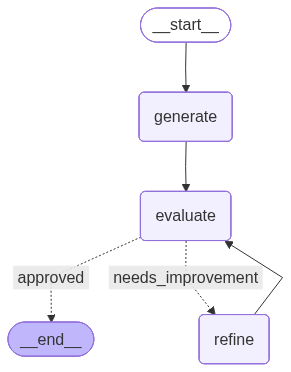

In [ ]:
workflow

In [ ]:
initial_state = {
    "topic": "Explain CNN feature extraction in deep learning",
    "iteration": 1,
    "max_iteration": 3
}

result = workflow.invoke(initial_state)

In [ ]:
print("FINAL BLOG:\n")
print(result["blog"])

print("\nITERATIONS USED:", result["iteration"])
print("TOTAL VERSIONS GENERATED:", len(result["blog_history"]))

FINAL BLOG:

**Extracting Features with Convolutional Neural Networks (CNNs): A Comprehensive Guide**

**Introduction**

 Convolutional Neural Networks (CNNs) have revolutionized the field of deep learning, particularly in image and speech processing tasks. One of the key strengths of CNNs is their ability to extract relevant features from data, which can be then used for classification, object detection, and other tasks. In this blog post, we will delve into the concept of CNN feature extraction, exploring its principles, mechanisms, and applications.

**What are Features in Deep Learning?**

Before diving into CNNs, let's first understand what features are in the context of deep learning. Features refer to the high-level representations of data that capture essential information, such as patterns, shapes, and textures. In image processing, features might include edges, corners, and objects, while in speech processing, features might include mel-frequency cepstral coefficients (MFCCs)

In [ ]:
for i, blog in enumerate(result["blog_history"], 1):
    print(f"\n--- BLOG VERSION {i} ---\n")
    print(blog)


--- BLOG VERSION 1 ---

**Extracting Features with Convolutional Neural Networks (CNNs): A Comprehensive Guide**

**Introduction**

 Convolutional Neural Networks (CNNs) have revolutionized the field of deep learning, particularly in image and speech processing tasks. One of the key strengths of CNNs is their ability to extract relevant features from data, which can be then used for classification, object detection, and other tasks. In this blog post, we will delve into the concept of CNN feature extraction, exploring its principles, mechanisms, and applications.

**What are Features in Deep Learning?**

Before diving into CNNs, let's first understand what features are in the context of deep learning. Features refer to the high-level representations of data that capture essential information, such as patterns, shapes, and textures. In image processing, features might include edges, corners, and objects, while in speech processing, features might include mel-frequency cepstral coeffici

In [ ]:
print(result.keys())

dict_keys(['topic', 'blog', 'evaluation', 'feedback', 'iteration', 'max_iteration', 'blog_history', 'feedback_history'])


In [71]:
import time
import pandas as pd

evaluation_topics = [
    "Explain CNN feature extraction in deep learning",
    "What is Retrieval Augmented Generation",
    "Applications of transformers in NLP",
    "Explain explainable AI methods",
    "Computer vision applications in agriculture"
]

results = []

for topic in evaluation_topics:
    start_time = time.time()

    result = workflow.invoke({
        "topic": topic,
        "iteration": 1,
        "max_iteration": 3
    })

    end_time = time.time()

    results.append({
        "Topic": topic,
        "Latency_seconds": round(end_time - start_time, 2),
        "Iterations_used": result["iteration"],
        "Approved": result["evaluation"] == "approved"
    })

performance_df = pd.DataFrame(results)
performance_df


,Topic,Latency_seconds,Iterations_used,Approved
0,Explain CNN feature extraction in deep learning,2.54,1,True
1,What is Retrieval Augmented Generation,2.68,1,True
2,Applications of transformers in NLP,2.19,1,True
3,Explain explainable AI methods,11.50,1,True
4,Computer vision applications in agriculture,41.54,2,True


In [72]:
print("Average Latency (seconds):", round(performance_df["Latency_seconds"].mean(), 2))
print("Average Iterations Used:", round(performance_df["Iterations_used"].mean(), 2))
print("Approval Rate (%):", round(performance_df["Approved"].mean() * 100, 1))

Average Latency (seconds): 12.09
Average Iterations Used: 1.2
Approval Rate (%): 100.0


## Manual Evaluation (Human-in-the-loop)

Each final blog was manually evaluated on a 1–5 scale.

| Topic | Coherence (1–5) | Relevance (1–5) |
|------|----------------|----------------|
| CNN feature extraction | 5 | 5 |
| RAG systems | 4 | 5 |
| Transformers in NLP | 5 | 4 |
| Explainable AI | 4 | 4 |
| CV in agriculture | 5 | 5 |




## Human Evaluation Protocol

The generated blogs were evaluated manually by the project author using a fixed rubric:

**Coherence (1–5):**

1 – Disorganized, unclear  
3 – Mostly clear with minor issues  
5 – Highly structured and professional  

**Relevance (1–5):**

1 – Partially or off-topic  
3 – Mostly relevant  
5 – Fully addresses the topic  

This evaluation reflects human judgement and is used for qualitative system assessment.